In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 95.1 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

## Processing for single image

In [ ]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/prathamesh.png")
# opencv BGR format and plt RGB channel format

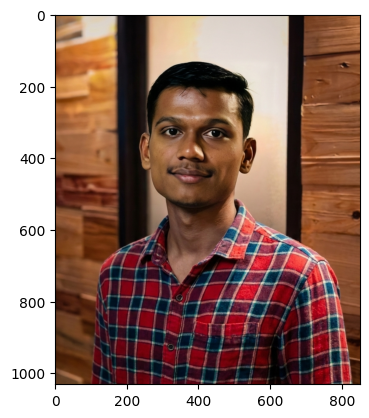

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.predict(img)

In [ ]:
results

[{'box': [271, 202, 238, 322],
  'confidence': 0.9999977350234985,
  'keypoints': {'nose': [372, 399],
   'mouth_right': [430, 459],
   'right_eye': [438, 341],
   'left_eye': [325, 333],
   'mouth_left': [328, 449]}}]

In [ ]:
x,y,w,h = results[0]['box']

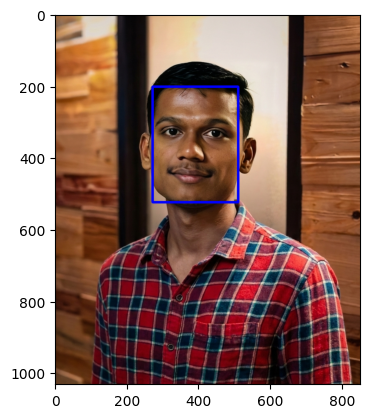

In [ ]:
img = cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 5)
plt.imshow(img)

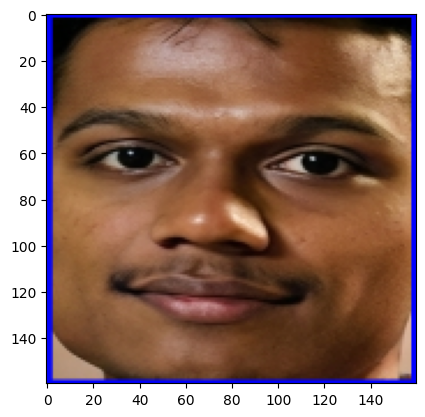

In [ ]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv2.resize(my_face, (160,160))
plt.imshow(my_face)

## Images before processing

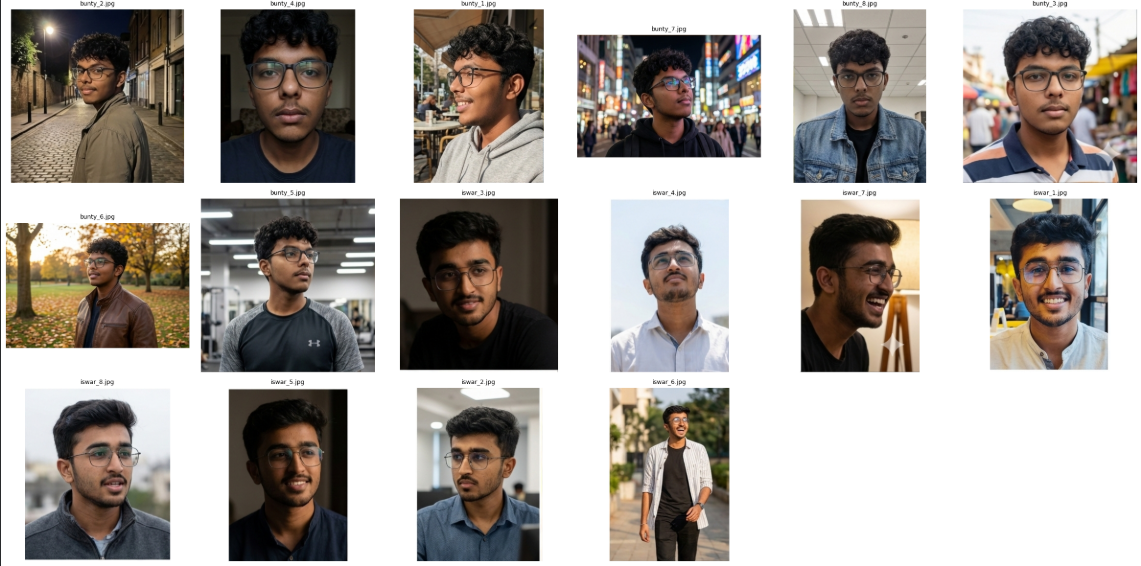

In [ ]:
from google.colab.patches import cv2_imshow
before=cv2.imread("/content/drive/MyDrive/Colab Notebooks/image-before.png")
cv2_imshow(before)


# Automate the preprocessing


In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv2.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        n_images = len(self.X)
        ncols = 6
        nrows = (n_images + ncols - 1) // ncols

        plt.figure(figsize=(6 * ncols-6, 6 * nrows-6))

        for num, image in enumerate(self.X):
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis("off")

        plt.tight_layout()
        plt.show()



In [ ]:
faceloading = FACELOADING("/content/drive/MyDrive/face-detect")
X, Y = faceloading.load_classes()

Loaded successfully: 0
Loaded successfully: 8
Loaded successfully: 8


In [ ]:
faceloading.plot_images()

Output hidden; open in https://colab.research.google.com to view.

# FaceNet part (for emdeddings)

In [ ]:
!pip install facenet_pytorch

In [ ]:
from facenet_pytorch import InceptionResnetV1
import torch

model = InceptionResnetV1(pretrained='vggface2').eval()

def get_embedding_torch(face_img):
    face_img = torch.tensor(face_img).permute(2, 0, 1)  # HWC -> CHW
    face_img = face_img.unsqueeze(0).float() / 255.0    # (1, 3, 160, 160)

    with torch.no_grad():
        embedding = model(face_img)

    return embedding[0].numpy()


In [ ]:
EMBEDDED_X = []

for img in X:   # X: numpy array or list of RGB face crops
    try:
        emb = get_embedding_torch(img)
        EMBEDDED_X.append(emb)
    except Exception as e:
        print(" Embedding failed:", e)

In [ ]:
np.savez_compressed('faces_embeddings_done_2classes.npz', EMBEDDED_X, Y)

# SVM model


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

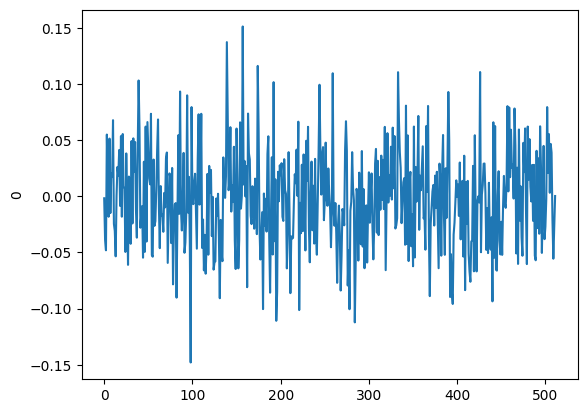

In [ ]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [ ]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [ ]:
from sklearn.svm import SVC
model_svc = SVC(kernel='linear', probability=True)
model_svc.fit(X_train, Y_train)

In [ ]:
ypreds_train = model_svc.predict(X_train)
ypreds_test = model_svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [ ]:
accuracy_score(Y_test,ypreds_test)

1.0

## Inference

In [ ]:
t_im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/bunty-test.png")
#t_im = cv2.imread("/content/drive/MyDrive/Colab Notebooks/iswar-test.png")
t_im = cv2.cvtColor(t_im, cv2.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [ ]:
# after face detection
h_img, w_img, _ = t_im.shape

x = max(0, x)
y = max(0, y)
x2 = min(x + w, w_img)
y2 = min(y + h, h_img)

face = t_im[y:y2, x:x2]

face = cv2.resize(face, (160, 160))


In [ ]:
data = np.load('faces_embeddings_done_2classes.npz')
X = data['arr_0']   # embeddings
Y = data['arr_1']   # labels


In [ ]:
emb = get_embedding_torch(face)
emb = emb.reshape(1, -1)
ypreds = model_svc.predict(emb)


In [ ]:
ypreds

array([0])

In [ ]:
encoder.inverse_transform(ypreds)

array(['Bunty'], dtype='<U5')

In [ ]:
proba = model_svc.predict_proba(emb)
confidence = proba.max()


In [ ]:
proba

array([[0.84503746, 0.15496254]])

In [ ]:
confidence

0.8450374564452681

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[29, 34, 33],
        [30, 35, 34],
        [30, 34, 34],
        ...,
        [64, 68, 68],
        [62, 69, 69],
        [66, 70, 70]],

       [[29, 34, 33],
        [28, 32, 31],
        [29, 34, 33],
        ...,
        [63, 68, 67],
        [63, 69, 69],
        [63, 69, 69]],

       [[29, 33, 32],
        [29, 34, 33],
        [28, 33, 32],
        ...,
        [65, 71, 71],
        [66, 71, 71],
        [65, 72, 72]]], dtype=uint8)
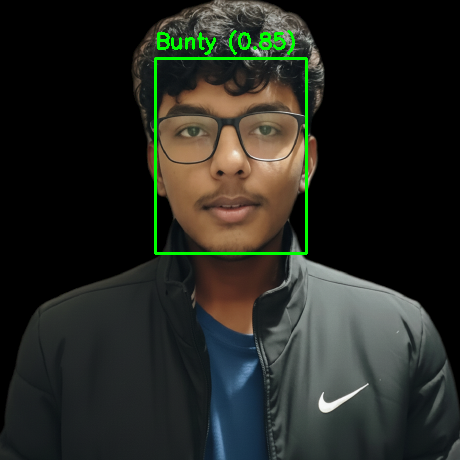

In [ ]:
import cv2
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/bunty-test.png")
name = encoder.inverse_transform(ypreds)[0]
score = confidence
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label_text = f"{name} ({score:.2f})"
cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
cv2.putText(
    image,
    label_text,
    (x, y-10),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7,
    (0,255,0),
    2
)


array([[[128, 131, 129],
        [131, 133, 129],
        [131, 132, 127],
        ...,
        [131, 157, 179],
        [122, 147, 170],
        [112, 140, 165]],

       [[126, 130, 128],
        [127, 130, 127],
        [128, 130, 127],
        ...,
        [131, 157, 179],
        [122, 147, 170],
        [113, 140, 165]],

       [[124, 128, 126],
        [124, 128, 125],
        [127, 126, 122],
        ...,
        [131, 158, 180],
        [122, 147, 170],
        [114, 141, 165]],

       ...,

       [[ 38,  39,  43],
        [ 38,  39,  43],
        [ 35,  36,  40],
        ...,
        [ 70,  52,  45],
        [ 72,  54,  48],
        [ 73,  57,  52]],

       [[ 38,  39,  43],
        [ 37,  38,  43],
        [ 36,  38,  42],
        ...,
        [ 70,  51,  44],
        [ 71,  53,  47],
        [ 73,  57,  53]],

       [[ 37,  39,  43],
        [ 36,  38,  43],
        [ 36,  38,  43],
        ...,
        [ 70,  51,  44],
        [ 71,  53,  47],
        [ 72,  57,  55]]], dtype=uint8)
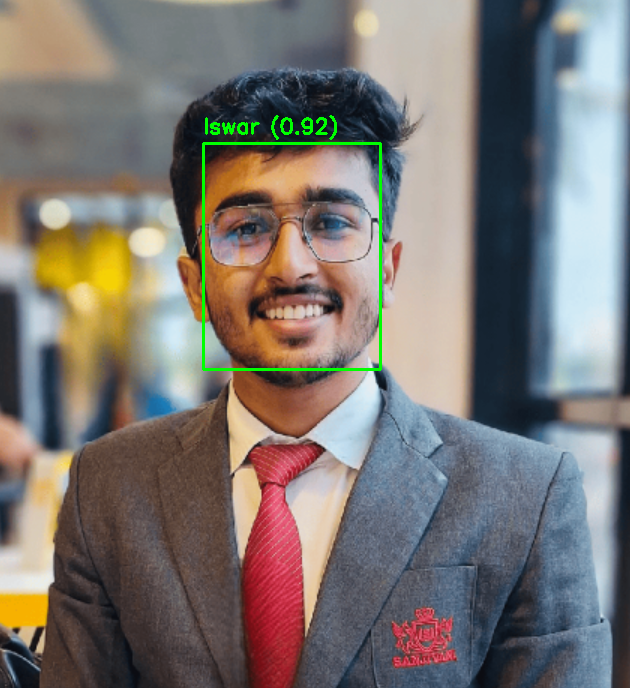

In [ ]:
import cv2
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/iswar-test.png")
name = encoder.inverse_transform(ypreds)[0]
score = confidence
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label_text = f"{name} ({score:.2f})"
cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
cv2.putText(
    image,
    label_text,
    (x, y-10),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.7,
    (0,255,0),
    2
)
